<a href="https://colab.research.google.com/github/esemlak/esemlak/blob/main/billiard_csv_tensorflow_model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [545]:
#!unzip -o /content/colab_train_big.zip
!pip3 install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [546]:
DATASET_PATH = "/content/colab_train_big.csv"
LABEL_NAME = "SCORE"

# "r" for regression and "c" for classification
# for classification, the number of output nodes is automatically determined
TASK = "r"

# don't change the dummy batch size. There is a small bug in tensorflow.
# to get around that bug, dummy batch size is used
DUMMY_BATCH_SIZE = 5
BATCH_SIZE = 100
EPOCHS = 100
TRAIN_FRAC = 0.8

CHECKPOINT_DIR = "/content/"

In [547]:
from collections import defaultdict
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner as kt

import IPython

# This function will give us a fresh dataset object

In [548]:
def get_dataset(batch_size = 5):
    return tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = batch_size,
        label_name = LABEL_NAME,
        num_epochs = 1,
        field_delim= ';'
    )

# If classification, Find Number of labels (for output nodes)

In [549]:
unique_labels = set()

unique_labels.add("VX")
unique_labels.add("VY")
num_labels = len(unique_labels)

OUTPUT_NODES = num_labels
    
print(unique_labels)

print("output nodes: ", OUTPUT_NODES)

{'VY', 'VX'}
output nodes:  2


**Test**

In [550]:
model_inputs = {}

#dataset = tf.data.experimental.make_csv_dataset(
#        DATASET_PATH,
#        batch_size = DUMMY_BATCH_SIZE,
#        label_name = LABEL_NAME,
#        num_epochs = 1,
#        header = True,
#    )

#iterator = dataset.as_numpy_iterator()
#print(next(iterator))

# Creating the Model Inputs as a dictionary

In [551]:
model_inputs = {}

for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    for col_name, col_values in batch.items():
        if (col_name == 'X1' or col_name == 'X2' or col_name == 'X3' or col_name == 'X4' or col_name == 'Y1' or col_name == 'Y2' or col_name == 'Y3' or col_name == 'Y4'):
          model_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)

In [552]:
model_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>}

## split these inputs into their own dictionaries based on the data type

In [553]:
float_inputs = {}

for col_name, col_input in model_inputs.items():
  
    
    if col_input.dtype == tf.float32:
        float_inputs[col_name] = col_input
    


In [554]:
float_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>}

In [555]:
def numerical_input_processor(inputs):
    if not inputs:
        return
    
    concat = None
    if len(inputs.values()) > 1:
        concat = tf.keras.layers.Concatenate()(list(inputs.values()))
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()

    for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)    

        norm.adapt(data)

    # mean_log = []

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)

        norm.adapt(data)        
        # mean_log.append(norm.mean.numpy())    

    if concat is not None:
        numeric_layer = norm(concat)
    else:
        numeric_layer = norm(list(inputs.values())[0])
    
    return numeric_layer

## PreProcess the inputs

In [556]:
float_layer = numerical_input_processor(float_inputs)

In [557]:
float_layer

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'normalization_13')>

## add all the input layers to a list

## Create a preprocessing keras model

In [558]:
preprocessing_head = tf.keras.Model(model_inputs, float_layer)

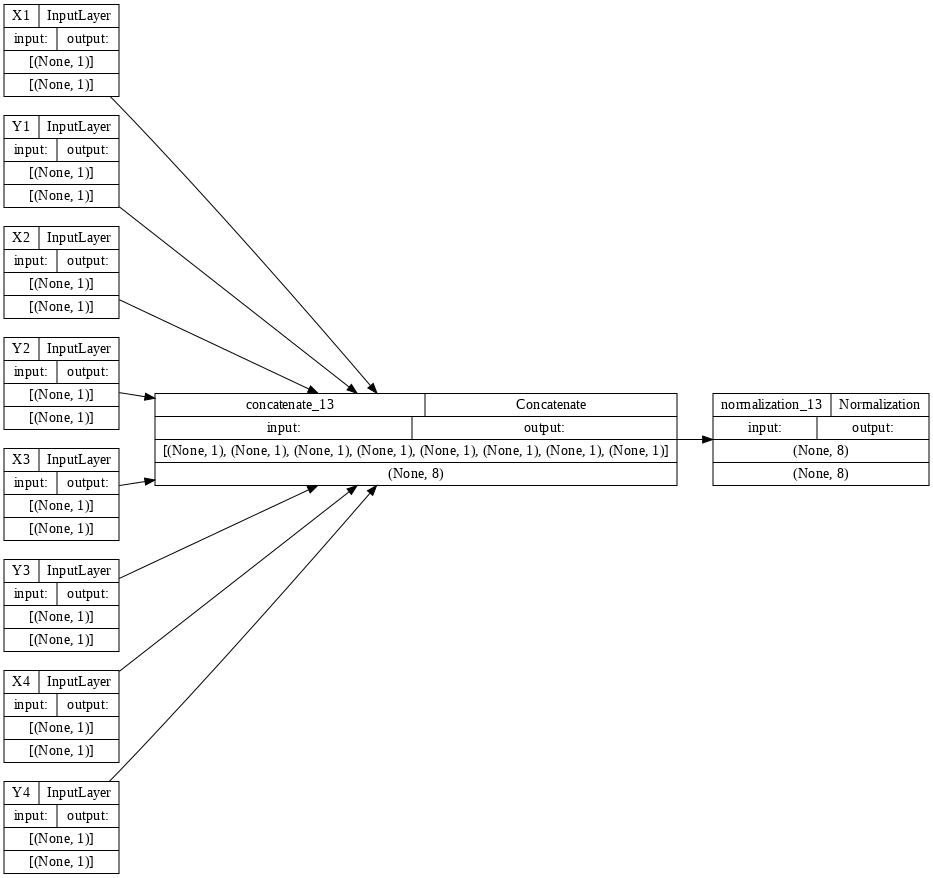

In [559]:
tf.keras.utils.plot_model(model = preprocessing_head, rankdir="LR", dpi=72, show_shapes=True, expand_nested=True, to_file="preprocessing_head.png")

## You can also see the preprocessed outputs for the given inputs

In [560]:
# preprocessing_head({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

# preprocessing_head({
#     "age" : np.array([22.0]),
#     "fare" : np.array([7.25]),
# })

## pass the model_inputs through the preprocessing_head

In [561]:
preprocessed_outputs = preprocessing_head(model_inputs)

In [562]:
num_preprocessed_outputs = list(preprocessed_outputs.shape)[-1]

In [563]:
num_preprocessed_outputs

8

## Find out how many batches should be used for training and how many for validation

In [564]:
dataset_size = 0

for _ in get_dataset(batch_size=BATCH_SIZE):
    dataset_size += 1

In [565]:
train_size = int(TRAIN_FRAC * dataset_size)

In [566]:
print(dataset_size)
print(train_size)

296
236


## Split the training and validation datasets


In [567]:
dataset = get_dataset(batch_size=BATCH_SIZE)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Set a caching mechanism that prefetches the next batch while the current batch is training

In [568]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## define early stopping and checkpointing callbacks

In [569]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "M.{epoch:02d}-{val_loss:.2f}"))

In [570]:
callbacks = [
    early_stopping_callback,
    checkpoint_callback,
]

In [571]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

## model builder function is used by keras-tuner to find the best parameters for a model

In [572]:
def model_builder(hp):
    loss_fn = {'xv_output': 'mse', 'yv_output': 'mse'}

    metrics={'xv_output':tf.keras.metrics.RootMeanSquaredError(), 'yv_output':tf.keras.metrics.RootMeanSquaredError()}
 
    kernel_hp = hp.Choice('kernel_regularization', values = [0.01, 0.001, 0.0001, 0.00001])
    activation_hp = hp.Choice("activation", values=["elu", "relu"])
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=train_size*1000,
        decay_rate=1,
        staircase=False
    )


    input_layer = tf.keras.layers.Input(shape=8)

    first_dense = tf.keras.layers.Dense(units='8', activation='relu')(preprocessed_outputs )
    
    #XV output will be fed from the first dense
    xv_output = tf.keras.layers.Dense(units='1', name='xv_output')(first_dense)
    
    second_dense = tf.keras.layers.Dense(units='8',activation='relu')(first_dense)
    
    #YV output will be fed from the second dense
    yv_output = tf.keras.layers.Dense(units='1',name='yv_output')(second_dense)

    
    model = tf.keras.Model(model_inputs, outputs = [xv_output, yv_output])
    
    model.compile(loss=loss_fn, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  metrics=metrics
    )
  
    return model



## initialize keras tuner

In [573]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_dir',
                     project_name = 'tuner')

In [574]:
tuner.search(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10,
    callbacks = [ClearTrainingOutput()]
)

In [575]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## These are the best model parameters

In [576]:
best_hps.values

{'kernel_regularization': 0.0001,
 'activation': 'elu',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [577]:
model = tuner.hypermodel.build(best_hps)

In [578]:
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X2 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X3 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X4 (InputLayer)                [(None, 1)]          0           []                               
                                                                                           

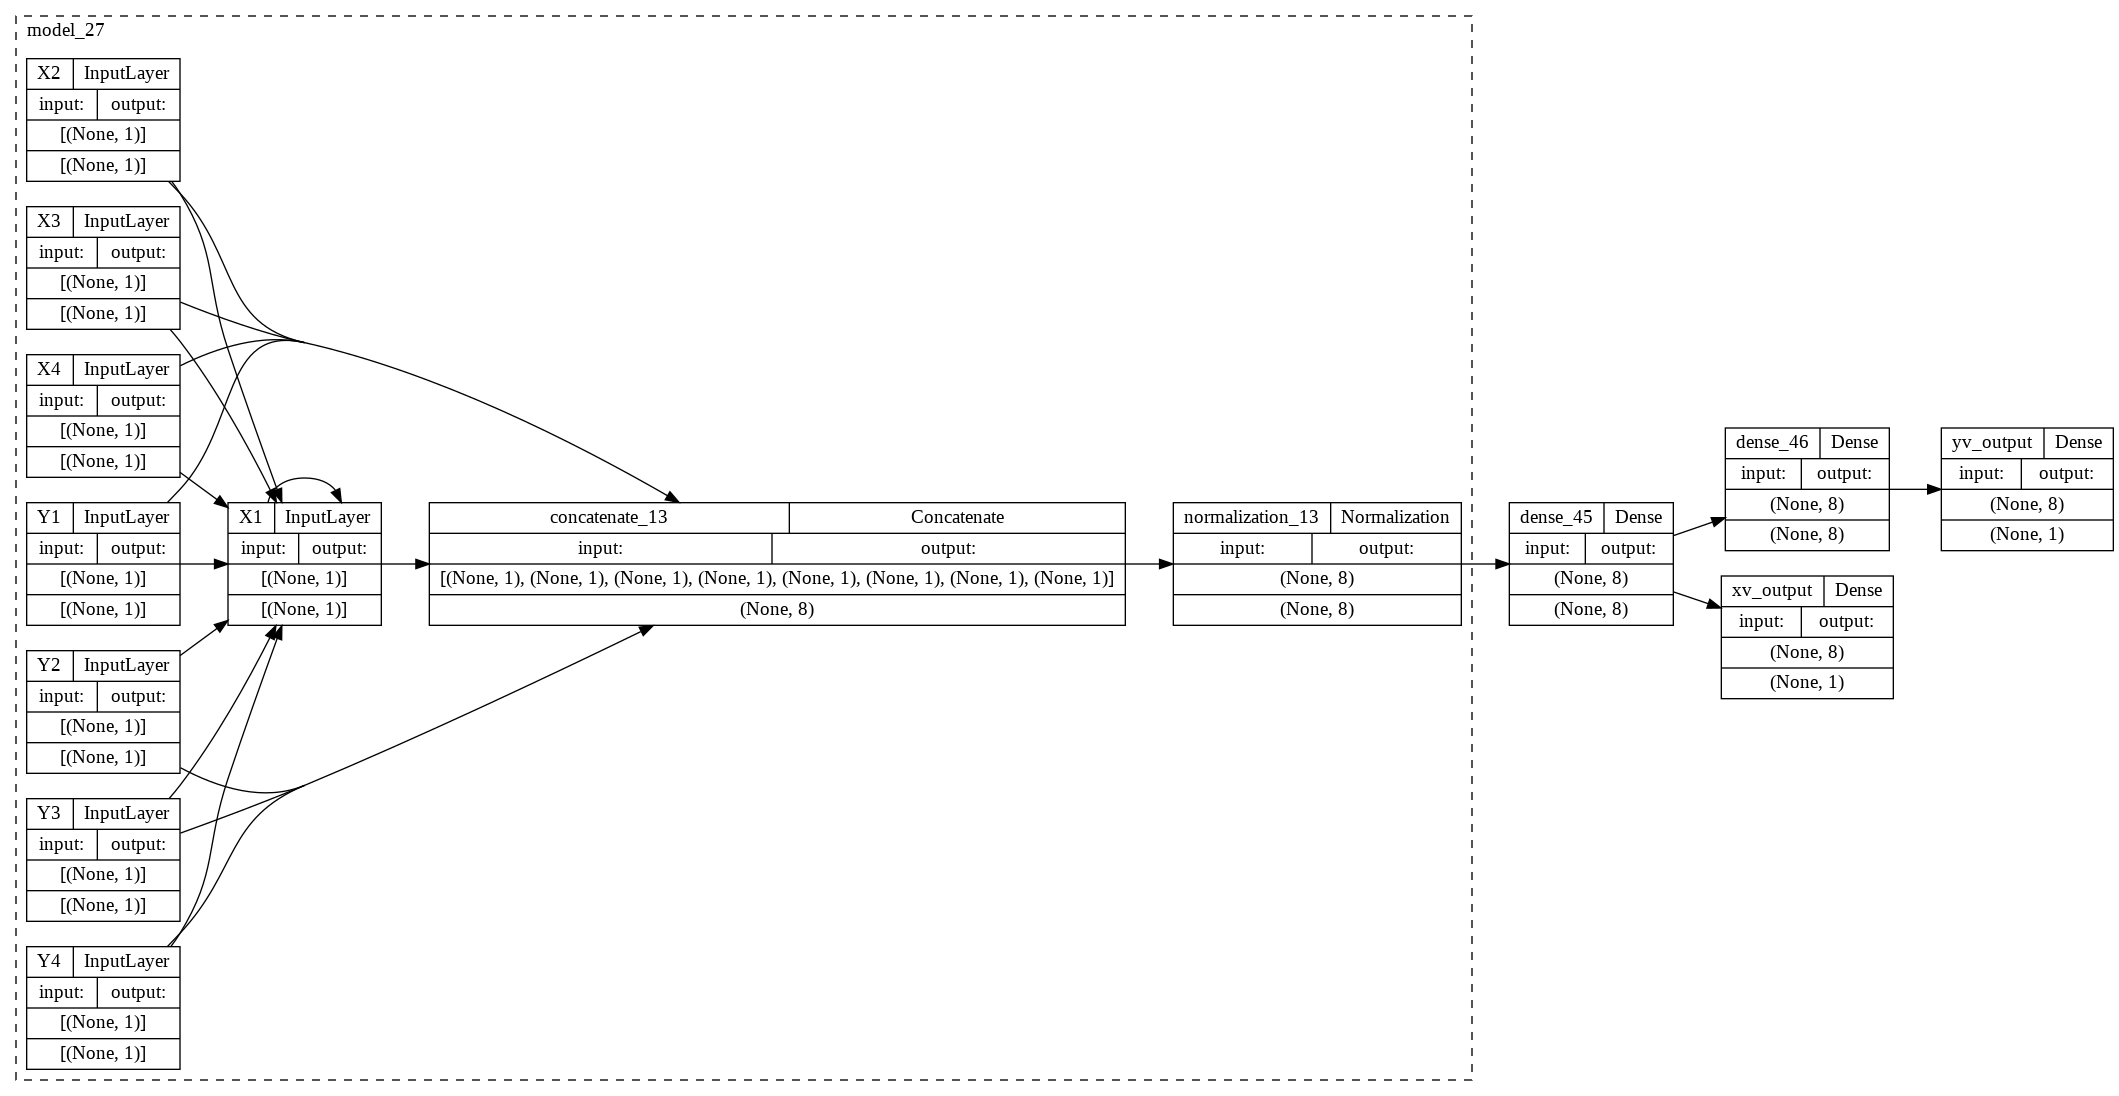

In [579]:
tf.keras.utils.plot_model(model = model, rankdir="LR", dpi=96, show_shapes=True, expand_nested=True, to_file="model.png")

## Find out training and validation losses with untrained model

In [580]:
# loss with un-trained model
model.evaluate(train_dataset)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['VX', 'VY'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


236/236 [==============================] - 2s 4ms/step - loss: 535.2990 - xv_output_loss: 269.9879 - yv_output_loss: 265.3111 - xv_output_root_mean_squared_error: 16.4313 - yv_output_root_mean_squared_error: 16.2884


[535.2990112304688,
 269.98785400390625,
 265.31109619140625,
 16.431306838989258,
 16.288372039794922]

In [581]:
# val_loss with un-trained model
model.evaluate(val_dataset)

60/60 [==============================] - 1s 5ms/step - loss: 539.6933 - xv_output_loss: 272.1595 - yv_output_loss: 267.5339 - xv_output_root_mean_squared_error: 16.4973 - yv_output_root_mean_squared_error: 16.3565


[539.6932983398438,
 272.1595153808594,
 267.53387451171875,
 16.497257232666016,
 16.356462478637695]

## Train the model

In [582]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    callbacks=callbacks,
    epochs=EPOCHS)

Epoch 1/100
    231/Unknown - 3s 6ms/step - loss: 132.6669 - xv_output_loss: 69.2432 - yv_output_loss: 63.4237 - xv_output_root_mean_squared_error: 8.3212 - yv_output_root_mean_squared_error: 7.9639

236/236 [==============================] - 7s 23ms/step - loss: 131.2507 - xv_output_loss: 68.4709 - yv_output_loss: 62.7799 - xv_output_root_mean_squared_error: 8.2747 - yv_output_root_mean_squared_error: 7.9234 - val_loss: 60.7001 - val_xv_output_loss: 30.4463 - val_yv_output_loss: 30.2538 - val_xv_output_root_mean_squared_error: 5.5178 - val_yv_output_root_mean_squared_error: 5.5003
Epoch 2/100
231/236 [============================>.] - ETA: 0s - loss: 61.5768 - xv_output_loss: 30.8108 - yv_output_loss: 30.7660 - xv_output_root_mean_squared_error: 5.5507 - yv_output_root_mean_squared_error: 5.5467

236/236 [==============================] - 5s 22ms/step - loss: 61.6412 - xv_output_loss: 30.8408 - yv_output_loss: 30.8004 - xv_output_root_mean_squared_error: 5.5534 - yv_output_root_mean_squared_error: 5.5498 - val_loss: 60.0317 - val_xv_output_loss: 30.1122 - val_yv_output_loss: 29.9195 - val_xv_output_root_mean_squared_error: 5.4875 - val_yv_output_root_mean_squared_error: 5.4699
Epoch 3/100
236/236 [==============================] - ETA: 0s - loss: 61.1875 - xv_output_loss: 30.6122 - yv_output_loss: 30.5753 - xv_output_root_mean_squared_error: 5.5328 - yv_output_root_mean_squared_error: 5.5295

236/236 [==============================] - 2s 9ms/step - loss: 61.1875 - xv_output_loss: 30.6122 - yv_output_loss: 30.5753 - xv_output_root_mean_squared_error: 5.5328 - yv_output_root_mean_squared_error: 5.5295 - val_loss: 59.8439 - val_xv_output_loss: 30.0039 - val_yv_output_loss: 29.8400 - val_xv_output_root_mean_squared_error: 5.4776 - val_yv_output_root_mean_squared_error: 5.4626
Epoch 4/100
235/236 [============================>.] - ETA: 0s - loss: 60.9822 - xv_output_loss: 30.4858 - yv_output_loss: 30.4965 - xv_output_root_mean_squared_error: 5.5214 - yv_output_root_mean_squared_error: 5.5224

236/236 [==============================] - 2s 9ms/step - loss: 61.0091 - xv_output_loss: 30.4988 - yv_output_loss: 30.5103 - xv_output_root_mean_squared_error: 5.5226 - yv_output_root_mean_squared_error: 5.5236 - val_loss: 59.7542 - val_xv_output_loss: 29.9319 - val_yv_output_loss: 29.8222 - val_xv_output_root_mean_squared_error: 5.4710 - val_yv_output_root_mean_squared_error: 5.4610
Epoch 5/100
225/236 [===========================>..] - ETA: 0s - loss: 60.8189 - xv_output_loss: 30.3829 - yv_output_loss: 30.4360 - xv_output_root_mean_squared_error: 5.5121 - yv_output_root_mean_squared_error: 5.5169

236/236 [==============================] - 2s 10ms/step - loss: 60.9102 - xv_output_loss: 30.4263 - yv_output_loss: 30.4839 - xv_output_root_mean_squared_error: 5.5160 - yv_output_root_mean_squared_error: 5.5212 - val_loss: 59.6965 - val_xv_output_loss: 29.8923 - val_yv_output_loss: 29.8041 - val_xv_output_root_mean_squared_error: 5.4674 - val_yv_output_root_mean_squared_error: 5.4593
Epoch 6/100
231/236 [============================>.] - ETA: 0s - loss: 60.8110 - xv_output_loss: 30.3573 - yv_output_loss: 30.4537 - xv_output_root_mean_squared_error: 5.5097 - yv_output_root_mean_squared_error: 5.5185

236/236 [==============================] - 2s 9ms/step - loss: 60.8725 - xv_output_loss: 30.3865 - yv_output_loss: 30.4861 - xv_output_root_mean_squared_error: 5.5124 - yv_output_root_mean_squared_error: 5.5214 - val_loss: 59.6648 - val_xv_output_loss: 29.8737 - val_yv_output_loss: 29.7911 - val_xv_output_root_mean_squared_error: 5.4657 - val_yv_output_root_mean_squared_error: 5.4581
Epoch 7/100
229/236 [============================>.] - ETA: 0s - loss: 60.7798 - xv_output_loss: 30.3301 - yv_output_loss: 30.4496 - xv_output_root_mean_squared_error: 5.5073 - yv_output_root_mean_squared_error: 5.5181

236/236 [==============================] - 2s 9ms/step - loss: 60.8508 - xv_output_loss: 30.3649 - yv_output_loss: 30.4859 - xv_output_root_mean_squared_error: 5.5104 - yv_output_root_mean_squared_error: 5.5214 - val_loss: 59.6496 - val_xv_output_loss: 29.8607 - val_yv_output_loss: 29.7889 - val_xv_output_root_mean_squared_error: 5.4645 - val_yv_output_root_mean_squared_error: 5.4579
Epoch 8/100
231/236 [============================>.] - ETA: 0s - loss: 60.7755 - xv_output_loss: 30.3212 - yv_output_loss: 30.4543 - xv_output_root_mean_squared_error: 5.5065 - yv_output_root_mean_squared_error: 5.5185

236/236 [==============================] - 2s 10ms/step - loss: 60.8371 - xv_output_loss: 30.3504 - yv_output_loss: 30.4867 - xv_output_root_mean_squared_error: 5.5091 - yv_output_root_mean_squared_error: 5.5215 - val_loss: 59.6440 - val_xv_output_loss: 29.8542 - val_yv_output_loss: 29.7898 - val_xv_output_root_mean_squared_error: 5.4639 - val_yv_output_root_mean_squared_error: 5.4580
Epoch 9/100
232/236 [============================>.] - ETA: 0s - loss: 60.7627 - xv_output_loss: 30.3097 - yv_output_loss: 30.4529 - xv_output_root_mean_squared_error: 5.5054 - yv_output_root_mean_squared_error: 5.5184

236/236 [==============================] - 2s 10ms/step - loss: 60.8247 - xv_output_loss: 30.3396 - yv_output_loss: 30.4851 - xv_output_root_mean_squared_error: 5.5081 - yv_output_root_mean_squared_error: 5.5213 - val_loss: 59.6405 - val_xv_output_loss: 29.8506 - val_yv_output_loss: 29.7899 - val_xv_output_root_mean_squared_error: 5.4636 - val_yv_output_root_mean_squared_error: 5.4580
Epoch 10/100
231/236 [============================>.] - ETA: 0s - loss: 60.7566 - xv_output_loss: 30.3051 - yv_output_loss: 30.4515 - xv_output_root_mean_squared_error: 5.5050 - yv_output_root_mean_squared_error: 5.5183

236/236 [==============================] - 2s 9ms/step - loss: 60.8183 - xv_output_loss: 30.3343 - yv_output_loss: 30.4840 - xv_output_root_mean_squared_error: 5.5077 - yv_output_root_mean_squared_error: 5.5212 - val_loss: 59.6377 - val_xv_output_loss: 29.8474 - val_yv_output_loss: 29.7903 - val_xv_output_root_mean_squared_error: 5.4633 - val_yv_output_root_mean_squared_error: 5.4581
Epoch 11/100
225/236 [===========================>..] - ETA: 0s - loss: 60.7237 - xv_output_loss: 30.2862 - yv_output_loss: 30.4375 - xv_output_root_mean_squared_error: 5.5033 - yv_output_root_mean_squared_error: 5.5170

236/236 [==============================] - 3s 11ms/step - loss: 60.8133 - xv_output_loss: 30.3304 - yv_output_loss: 30.4829 - xv_output_root_mean_squared_error: 5.5073 - yv_output_root_mean_squared_error: 5.5211 - val_loss: 59.6305 - val_xv_output_loss: 29.8451 - val_yv_output_loss: 29.7854 - val_xv_output_root_mean_squared_error: 5.4631 - val_yv_output_root_mean_squared_error: 5.4576
Epoch 12/100
224/236 [===========================>..] - ETA: 0s - loss: 60.7062 - xv_output_loss: 30.2774 - yv_output_loss: 30.4288 - xv_output_root_mean_squared_error: 5.5025 - yv_output_root_mean_squared_error: 5.5162

236/236 [==============================] - 2s 9ms/step - loss: 60.8070 - xv_output_loss: 30.3273 - yv_output_loss: 30.4797 - xv_output_root_mean_squared_error: 5.5070 - yv_output_root_mean_squared_error: 5.5208 - val_loss: 59.6170 - val_xv_output_loss: 29.8394 - val_yv_output_loss: 29.7777 - val_xv_output_root_mean_squared_error: 5.4625 - val_yv_output_root_mean_squared_error: 5.4569
Epoch 13/100
231/236 [============================>.] - ETA: 0s - loss: 60.7424 - xv_output_loss: 30.2992 - yv_output_loss: 30.4432 - xv_output_root_mean_squared_error: 5.5045 - yv_output_root_mean_squared_error: 5.5175

236/236 [==============================] - 2s 10ms/step - loss: 60.8045 - xv_output_loss: 30.3281 - yv_output_loss: 30.4764 - xv_output_root_mean_squared_error: 5.5071 - yv_output_root_mean_squared_error: 5.5205 - val_loss: 59.6227 - val_xv_output_loss: 29.8466 - val_yv_output_loss: 29.7761 - val_xv_output_root_mean_squared_error: 5.4632 - val_yv_output_root_mean_squared_error: 5.4568
Epoch 14/100
229/236 [============================>.] - ETA: 0s - loss: 60.7287 - xv_output_loss: 30.2907 - yv_output_loss: 30.4380 - xv_output_root_mean_squared_error: 5.5037 - yv_output_root_mean_squared_error: 5.5171

236/236 [==============================] - 2s 10ms/step - loss: 60.7999 - xv_output_loss: 30.3253 - yv_output_loss: 30.4746 - xv_output_root_mean_squared_error: 5.5068 - yv_output_root_mean_squared_error: 5.5204 - val_loss: 59.6221 - val_xv_output_loss: 29.8431 - val_yv_output_loss: 29.7790 - val_xv_output_root_mean_squared_error: 5.4629 - val_yv_output_root_mean_squared_error: 5.4570
Epoch 15/100
236/236 [==============================] - ETA: 0s - loss: 60.7945 - xv_output_loss: 30.3234 - yv_output_loss: 30.4711 - xv_output_root_mean_squared_error: 5.5067 - yv_output_root_mean_squared_error: 5.5201

236/236 [==============================] - 2s 9ms/step - loss: 60.7945 - xv_output_loss: 30.3234 - yv_output_loss: 30.4711 - xv_output_root_mean_squared_error: 5.5067 - yv_output_root_mean_squared_error: 5.5201 - val_loss: 59.6189 - val_xv_output_loss: 29.8436 - val_yv_output_loss: 29.7753 - val_xv_output_root_mean_squared_error: 5.4629 - val_yv_output_root_mean_squared_error: 5.4567
Epoch 16/100
236/236 [==============================] - ETA: 0s - loss: 60.7872 - xv_output_loss: 30.3205 - yv_output_loss: 30.4666 - xv_output_root_mean_squared_error: 5.5064 - yv_output_root_mean_squared_error: 5.5197

236/236 [==============================] - 2s 11ms/step - loss: 60.7872 - xv_output_loss: 30.3205 - yv_output_loss: 30.4666 - xv_output_root_mean_squared_error: 5.5064 - yv_output_root_mean_squared_error: 5.5197 - val_loss: 59.6137 - val_xv_output_loss: 29.8400 - val_yv_output_loss: 29.7737 - val_xv_output_root_mean_squared_error: 5.4626 - val_yv_output_root_mean_squared_error: 5.4565
Epoch 17/100
234/236 [============================>.] - ETA: 0s - loss: 60.7786 - xv_output_loss: 30.3175 - yv_output_loss: 30.4611 - xv_output_root_mean_squared_error: 5.5061 - yv_output_root_mean_squared_error: 5.5192

236/236 [==============================] - 2s 9ms/step - loss: 60.7818 - xv_output_loss: 30.3183 - yv_output_loss: 30.4635 - xv_output_root_mean_squared_error: 5.5062 - yv_output_root_mean_squared_error: 5.5194 - val_loss: 59.6104 - val_xv_output_loss: 29.8379 - val_yv_output_loss: 29.7725 - val_xv_output_root_mean_squared_error: 5.4624 - val_yv_output_root_mean_squared_error: 5.4564
Epoch 18/100
226/236 [===========================>..] - ETA: 0s - loss: 60.7291 - xv_output_loss: 30.2934 - yv_output_loss: 30.4356 - xv_output_root_mean_squared_error: 5.5039 - yv_output_root_mean_squared_error: 5.5168

236/236 [==============================] - 2s 9ms/step - loss: 60.7772 - xv_output_loss: 30.3159 - yv_output_loss: 30.4612 - xv_output_root_mean_squared_error: 5.5060 - yv_output_root_mean_squared_error: 5.5192 - val_loss: 59.6075 - val_xv_output_loss: 29.8369 - val_yv_output_loss: 29.7705 - val_xv_output_root_mean_squared_error: 5.4623 - val_yv_output_root_mean_squared_error: 5.4562
Epoch 19/100
233/236 [============================>.] - ETA: 0s - loss: 60.7233 - xv_output_loss: 30.2920 - yv_output_loss: 30.4312 - xv_output_root_mean_squared_error: 5.5038 - yv_output_root_mean_squared_error: 5.5164

236/236 [==============================] - 2s 9ms/step - loss: 60.7740 - xv_output_loss: 30.3152 - yv_output_loss: 30.4588 - xv_output_root_mean_squared_error: 5.5059 - yv_output_root_mean_squared_error: 5.5189 - val_loss: 59.6079 - val_xv_output_loss: 29.8361 - val_yv_output_loss: 29.7719 - val_xv_output_root_mean_squared_error: 5.4622 - val_yv_output_root_mean_squared_error: 5.4564
Epoch 20/100
230/236 [============================>.] - ETA: 0s - loss: 60.6771 - xv_output_loss: 30.2688 - yv_output_loss: 30.4083 - xv_output_root_mean_squared_error: 5.5017 - yv_output_root_mean_squared_error: 5.5144

236/236 [==============================] - 2s 9ms/step - loss: 60.7703 - xv_output_loss: 30.3136 - yv_output_loss: 30.4567 - xv_output_root_mean_squared_error: 5.5058 - yv_output_root_mean_squared_error: 5.5188 - val_loss: 59.6080 - val_xv_output_loss: 29.8381 - val_yv_output_loss: 29.7699 - val_xv_output_root_mean_squared_error: 5.4624 - val_yv_output_root_mean_squared_error: 5.4562
Epoch 21/100
230/236 [============================>.] - ETA: 0s - loss: 60.6735 - xv_output_loss: 30.2671 - yv_output_loss: 30.4064 - xv_output_root_mean_squared_error: 5.5016 - yv_output_root_mean_squared_error: 5.5142

236/236 [==============================] - 2s 10ms/step - loss: 60.7665 - xv_output_loss: 30.3117 - yv_output_loss: 30.4548 - xv_output_root_mean_squared_error: 5.5056 - yv_output_root_mean_squared_error: 5.5186 - val_loss: 59.6065 - val_xv_output_loss: 29.8373 - val_yv_output_loss: 29.7692 - val_xv_output_root_mean_squared_error: 5.4624 - val_yv_output_root_mean_squared_error: 5.4561
Epoch 22/100
227/236 [===========================>..] - ETA: 0s - loss: 60.7009 - xv_output_loss: 30.2802 - yv_output_loss: 30.4207 - xv_output_root_mean_squared_error: 5.5027 - yv_output_root_mean_squared_error: 5.5155

236/236 [==============================] - 2s 9ms/step - loss: 60.7651 - xv_output_loss: 30.3109 - yv_output_loss: 30.4542 - xv_output_root_mean_squared_error: 5.5055 - yv_output_root_mean_squared_error: 5.5185 - val_loss: 59.6084 - val_xv_output_loss: 29.8410 - val_yv_output_loss: 29.7674 - val_xv_output_root_mean_squared_error: 5.4627 - val_yv_output_root_mean_squared_error: 5.4559
Epoch 23/100
224/236 [===========================>..] - ETA: 0s - loss: 60.6612 - xv_output_loss: 30.2615 - yv_output_loss: 30.3997 - xv_output_root_mean_squared_error: 5.5010 - yv_output_root_mean_squared_error: 5.5136

236/236 [==============================] - 2s 9ms/step - loss: 60.7622 - xv_output_loss: 30.3106 - yv_output_loss: 30.4516 - xv_output_root_mean_squared_error: 5.5055 - yv_output_root_mean_squared_error: 5.5183 - val_loss: 59.6062 - val_xv_output_loss: 29.8354 - val_yv_output_loss: 29.7708 - val_xv_output_root_mean_squared_error: 5.4622 - val_yv_output_root_mean_squared_error: 5.4563
Epoch 24/100
230/236 [============================>.] - ETA: 0s - loss: 60.6665 - xv_output_loss: 30.2654 - yv_output_loss: 30.4011 - xv_output_root_mean_squared_error: 5.5014 - yv_output_root_mean_squared_error: 5.5137

236/236 [==============================] - 2s 9ms/step - loss: 60.7597 - xv_output_loss: 30.3097 - yv_output_loss: 30.4500 - xv_output_root_mean_squared_error: 5.5054 - yv_output_root_mean_squared_error: 5.5181 - val_loss: 59.6039 - val_xv_output_loss: 29.8341 - val_yv_output_loss: 29.7699 - val_xv_output_root_mean_squared_error: 5.4621 - val_yv_output_root_mean_squared_error: 5.4562
Epoch 25/100
229/236 [============================>.] - ETA: 0s - loss: 60.6884 - xv_output_loss: 30.2764 - yv_output_loss: 30.4120 - xv_output_root_mean_squared_error: 5.5024 - yv_output_root_mean_squared_error: 5.5147

236/236 [==============================] - 2s 9ms/step - loss: 60.7583 - xv_output_loss: 30.3093 - yv_output_loss: 30.4490 - xv_output_root_mean_squared_error: 5.5054 - yv_output_root_mean_squared_error: 5.5181 - val_loss: 59.6033 - val_xv_output_loss: 29.8334 - val_yv_output_loss: 29.7699 - val_xv_output_root_mean_squared_error: 5.4620 - val_yv_output_root_mean_squared_error: 5.4562
Epoch 26/100
225/236 [===========================>..] - ETA: 0s - loss: 60.6648 - xv_output_loss: 30.2658 - yv_output_loss: 30.3990 - xv_output_root_mean_squared_error: 5.5014 - yv_output_root_mean_squared_error: 5.5135

236/236 [==============================] - 2s 9ms/step - loss: 60.7546 - xv_output_loss: 30.3087 - yv_output_loss: 30.4459 - xv_output_root_mean_squared_error: 5.5053 - yv_output_root_mean_squared_error: 5.5178 - val_loss: 59.6021 - val_xv_output_loss: 29.8335 - val_yv_output_loss: 29.7686 - val_xv_output_root_mean_squared_error: 5.4620 - val_yv_output_root_mean_squared_error: 5.4561
Epoch 27/100
227/236 [===========================>..] - ETA: 0s - loss: 60.6870 - xv_output_loss: 30.2777 - yv_output_loss: 30.4094 - xv_output_root_mean_squared_error: 5.5025 - yv_output_root_mean_squared_error: 5.5145

236/236 [==============================] - 3s 11ms/step - loss: 60.7514 - xv_output_loss: 30.3078 - yv_output_loss: 30.4435 - xv_output_root_mean_squared_error: 5.5053 - yv_output_root_mean_squared_error: 5.5176 - val_loss: 59.6028 - val_xv_output_loss: 29.8315 - val_yv_output_loss: 29.7713 - val_xv_output_root_mean_squared_error: 5.4618 - val_yv_output_root_mean_squared_error: 5.4563
Epoch 28/100
230/236 [============================>.] - ETA: 0s - loss: 60.6578 - xv_output_loss: 30.2642 - yv_output_loss: 30.3936 - xv_output_root_mean_squared_error: 5.5013 - yv_output_root_mean_squared_error: 5.5130

236/236 [==============================] - 3s 11ms/step - loss: 60.7503 - xv_output_loss: 30.3081 - yv_output_loss: 30.4422 - xv_output_root_mean_squared_error: 5.5053 - yv_output_root_mean_squared_error: 5.5174 - val_loss: 59.6008 - val_xv_output_loss: 29.8311 - val_yv_output_loss: 29.7697 - val_xv_output_root_mean_squared_error: 5.4618 - val_yv_output_root_mean_squared_error: 5.4562
Epoch 29/100
232/236 [============================>.] - ETA: 0s - loss: 60.6865 - xv_output_loss: 30.2792 - yv_output_loss: 30.4073 - xv_output_root_mean_squared_error: 5.5027 - yv_output_root_mean_squared_error: 5.5143

236/236 [==============================] - 2s 9ms/step - loss: 60.7472 - xv_output_loss: 30.3068 - yv_output_loss: 30.4405 - xv_output_root_mean_squared_error: 5.5052 - yv_output_root_mean_squared_error: 5.5173 - val_loss: 59.5988 - val_xv_output_loss: 29.8293 - val_yv_output_loss: 29.7696 - val_xv_output_root_mean_squared_error: 5.4616 - val_yv_output_root_mean_squared_error: 5.4562
Epoch 30/100
226/236 [===========================>..] - ETA: 0s - loss: 60.6979 - xv_output_loss: 30.2839 - yv_output_loss: 30.4140 - xv_output_root_mean_squared_error: 5.5031 - yv_output_root_mean_squared_error: 5.5149

236/236 [==============================] - 2s 9ms/step - loss: 60.7458 - xv_output_loss: 30.3059 - yv_output_loss: 30.4399 - xv_output_root_mean_squared_error: 5.5051 - yv_output_root_mean_squared_error: 5.5172 - val_loss: 59.6017 - val_xv_output_loss: 29.8371 - val_yv_output_loss: 29.7646 - val_xv_output_root_mean_squared_error: 5.4623 - val_yv_output_root_mean_squared_error: 5.4557
Epoch 31/100
232/236 [============================>.] - ETA: 0s - loss: 60.6815 - xv_output_loss: 30.2771 - yv_output_loss: 30.4044 - xv_output_root_mean_squared_error: 5.5025 - yv_output_root_mean_squared_error: 5.5140

236/236 [==============================] - 2s 9ms/step - loss: 60.7418 - xv_output_loss: 30.3045 - yv_output_loss: 30.4373 - xv_output_root_mean_squared_error: 5.5050 - yv_output_root_mean_squared_error: 5.5170 - val_loss: 59.6009 - val_xv_output_loss: 29.8353 - val_yv_output_loss: 29.7656 - val_xv_output_root_mean_squared_error: 5.4622 - val_yv_output_root_mean_squared_error: 5.4558
Epoch 32/100
230/236 [============================>.] - ETA: 0s - loss: 60.6488 - xv_output_loss: 30.2609 - yv_output_loss: 30.3878 - xv_output_root_mean_squared_error: 5.5010 - yv_output_root_mean_squared_error: 5.5125

236/236 [==============================] - 3s 11ms/step - loss: 60.7402 - xv_output_loss: 30.3043 - yv_output_loss: 30.4359 - xv_output_root_mean_squared_error: 5.5049 - yv_output_root_mean_squared_error: 5.5169 - val_loss: 59.5965 - val_xv_output_loss: 29.8349 - val_yv_output_loss: 29.7616 - val_xv_output_root_mean_squared_error: 5.4621 - val_yv_output_root_mean_squared_error: 5.4554
Epoch 33/100
232/236 [============================>.] - ETA: 0s - loss: 60.6759 - xv_output_loss: 30.2745 - yv_output_loss: 30.4014 - xv_output_root_mean_squared_error: 5.5022 - yv_output_root_mean_squared_error: 5.5137

236/236 [==============================] - 2s 9ms/step - loss: 60.7358 - xv_output_loss: 30.3016 - yv_output_loss: 30.4342 - xv_output_root_mean_squared_error: 5.5047 - yv_output_root_mean_squared_error: 5.5167 - val_loss: 59.5958 - val_xv_output_loss: 29.8342 - val_yv_output_loss: 29.7616 - val_xv_output_root_mean_squared_error: 5.4621 - val_yv_output_root_mean_squared_error: 5.4554
Epoch 34/100
236/236 [==============================] - ETA: 0s - loss: 60.7343 - xv_output_loss: 30.3017 - yv_output_loss: 30.4325 - xv_output_root_mean_squared_error: 5.5047 - yv_output_root_mean_squared_error: 5.5166

236/236 [==============================] - 2s 9ms/step - loss: 60.7343 - xv_output_loss: 30.3017 - yv_output_loss: 30.4325 - xv_output_root_mean_squared_error: 5.5047 - yv_output_root_mean_squared_error: 5.5166 - val_loss: 59.5969 - val_xv_output_loss: 29.8312 - val_yv_output_loss: 29.7657 - val_xv_output_root_mean_squared_error: 5.4618 - val_yv_output_root_mean_squared_error: 5.4558
Epoch 35/100
226/236 [===========================>..] - ETA: 0s - loss: 60.6928 - xv_output_loss: 30.2779 - yv_output_loss: 30.4149 - xv_output_root_mean_squared_error: 5.5025 - yv_output_root_mean_squared_error: 5.5150

236/236 [==============================] - 2s 9ms/step - loss: 60.7397 - xv_output_loss: 30.2987 - yv_output_loss: 30.4410 - xv_output_root_mean_squared_error: 5.5044 - yv_output_root_mean_squared_error: 5.5173 - val_loss: 59.5958 - val_xv_output_loss: 29.8307 - val_yv_output_loss: 29.7650 - val_xv_output_root_mean_squared_error: 5.4618 - val_yv_output_root_mean_squared_error: 5.4557
Epoch 36/100
227/236 [===========================>..] - ETA: 0s - loss: 60.6614 - xv_output_loss: 30.2686 - yv_output_loss: 30.3928 - xv_output_root_mean_squared_error: 5.5017 - yv_output_root_mean_squared_error: 5.5130

236/236 [==============================] - 2s 10ms/step - loss: 60.7251 - xv_output_loss: 30.2975 - yv_output_loss: 30.4276 - xv_output_root_mean_squared_error: 5.5043 - yv_output_root_mean_squared_error: 5.5161 - val_loss: 59.5988 - val_xv_output_loss: 29.8309 - val_yv_output_loss: 29.7679 - val_xv_output_root_mean_squared_error: 5.4618 - val_yv_output_root_mean_squared_error: 5.4560
Epoch 37/100
236/236 [==============================] - ETA: 0s - loss: 60.7228 - xv_output_loss: 30.2979 - yv_output_loss: 30.4249 - xv_output_root_mean_squared_error: 5.5044 - yv_output_root_mean_squared_error: 5.5159

236/236 [==============================] - 3s 11ms/step - loss: 60.7228 - xv_output_loss: 30.2979 - yv_output_loss: 30.4249 - xv_output_root_mean_squared_error: 5.5044 - yv_output_root_mean_squared_error: 5.5159 - val_loss: 59.5970 - val_xv_output_loss: 29.8298 - val_yv_output_loss: 29.7671 - val_xv_output_root_mean_squared_error: 5.4617 - val_yv_output_root_mean_squared_error: 5.4559
Epoch 38/100
226/236 [===========================>..] - ETA: 0s - loss: 60.6751 - xv_output_loss: 30.2791 - yv_output_loss: 30.3959 - xv_output_root_mean_squared_error: 5.5026 - yv_output_root_mean_squared_error: 5.5132

236/236 [==============================] - 2s 10ms/step - loss: 60.7221 - xv_output_loss: 30.2998 - yv_output_loss: 30.4224 - xv_output_root_mean_squared_error: 5.5045 - yv_output_root_mean_squared_error: 5.5156 - val_loss: 59.5947 - val_xv_output_loss: 29.8272 - val_yv_output_loss: 29.7675 - val_xv_output_root_mean_squared_error: 5.4614 - val_yv_output_root_mean_squared_error: 5.4560
Epoch 39/100
232/236 [============================>.] - ETA: 0s - loss: 60.6585 - xv_output_loss: 30.2699 - yv_output_loss: 30.3886 - xv_output_root_mean_squared_error: 5.5018 - yv_output_root_mean_squared_error: 5.5126

236/236 [==============================] - 2s 9ms/step - loss: 60.7174 - xv_output_loss: 30.2964 - yv_output_loss: 30.4210 - xv_output_root_mean_squared_error: 5.5042 - yv_output_root_mean_squared_error: 5.5155 - val_loss: 59.5908 - val_xv_output_loss: 29.8279 - val_yv_output_loss: 29.7629 - val_xv_output_root_mean_squared_error: 5.4615 - val_yv_output_root_mean_squared_error: 5.4555
Epoch 40/100
224/236 [===========================>..] - ETA: 0s - loss: 60.6164 - xv_output_loss: 30.2488 - yv_output_loss: 30.3676 - xv_output_root_mean_squared_error: 5.4999 - yv_output_root_mean_squared_error: 5.5107

236/236 [==============================] - 2s 9ms/step - loss: 60.7152 - xv_output_loss: 30.2967 - yv_output_loss: 30.4185 - xv_output_root_mean_squared_error: 5.5042 - yv_output_root_mean_squared_error: 5.5153 - val_loss: 59.5900 - val_xv_output_loss: 29.8269 - val_yv_output_loss: 29.7631 - val_xv_output_root_mean_squared_error: 5.4614 - val_yv_output_root_mean_squared_error: 5.4556
Epoch 41/100
236/236 [==============================] - ETA: 0s - loss: 60.7151 - xv_output_loss: 30.2972 - yv_output_loss: 30.4178 - xv_output_root_mean_squared_error: 5.5043 - yv_output_root_mean_squared_error: 5.5152

236/236 [==============================] - 2s 9ms/step - loss: 60.7151 - xv_output_loss: 30.2972 - yv_output_loss: 30.4178 - xv_output_root_mean_squared_error: 5.5043 - yv_output_root_mean_squared_error: 5.5152 - val_loss: 59.5932 - val_xv_output_loss: 29.8272 - val_yv_output_loss: 29.7660 - val_xv_output_root_mean_squared_error: 5.4614 - val_yv_output_root_mean_squared_error: 5.4558
Epoch 42/100
235/236 [============================>.] - ETA: 0s - loss: 60.6828 - xv_output_loss: 30.2832 - yv_output_loss: 30.3997 - xv_output_root_mean_squared_error: 5.5030 - yv_output_root_mean_squared_error: 5.5136

236/236 [==============================] - 2s 9ms/step - loss: 60.7102 - xv_output_loss: 30.2965 - yv_output_loss: 30.4136 - xv_output_root_mean_squared_error: 5.5042 - yv_output_root_mean_squared_error: 5.5149 - val_loss: 59.5862 - val_xv_output_loss: 29.8277 - val_yv_output_loss: 29.7586 - val_xv_output_root_mean_squared_error: 5.4615 - val_yv_output_root_mean_squared_error: 5.4551
Epoch 43/100
233/236 [============================>.] - ETA: 0s - loss: 60.6590 - xv_output_loss: 30.2736 - yv_output_loss: 30.3854 - xv_output_root_mean_squared_error: 5.5021 - yv_output_root_mean_squared_error: 5.5123

236/236 [==============================] - 3s 11ms/step - loss: 60.7074 - xv_output_loss: 30.2950 - yv_output_loss: 30.4124 - xv_output_root_mean_squared_error: 5.5041 - yv_output_root_mean_squared_error: 5.5147 - val_loss: 59.5854 - val_xv_output_loss: 29.8259 - val_yv_output_loss: 29.7594 - val_xv_output_root_mean_squared_error: 5.4613 - val_yv_output_root_mean_squared_error: 5.4552
Epoch 44/100
225/236 [===========================>..] - ETA: 0s - loss: 60.6176 - xv_output_loss: 30.2531 - yv_output_loss: 30.3646 - xv_output_root_mean_squared_error: 5.5003 - yv_output_root_mean_squared_error: 5.5104

236/236 [==============================] - 2s 9ms/step - loss: 60.7052 - xv_output_loss: 30.2949 - yv_output_loss: 30.4104 - xv_output_root_mean_squared_error: 5.5041 - yv_output_root_mean_squared_error: 5.5146 - val_loss: 59.5844 - val_xv_output_loss: 29.8276 - val_yv_output_loss: 29.7569 - val_xv_output_root_mean_squared_error: 5.4615 - val_yv_output_root_mean_squared_error: 5.4550
Epoch 45/100
228/236 [===========================>..] - ETA: 0s - loss: 60.6013 - xv_output_loss: 30.2469 - yv_output_loss: 30.3544 - xv_output_root_mean_squared_error: 5.4997 - yv_output_root_mean_squared_error: 5.5095

236/236 [==============================] - 2s 9ms/step - loss: 60.7034 - xv_output_loss: 30.2955 - yv_output_loss: 30.4080 - xv_output_root_mean_squared_error: 5.5041 - yv_output_root_mean_squared_error: 5.5143 - val_loss: 59.5849 - val_xv_output_loss: 29.8264 - val_yv_output_loss: 29.7585 - val_xv_output_root_mean_squared_error: 5.4614 - val_yv_output_root_mean_squared_error: 5.4551
Epoch 46/100
229/236 [============================>.] - ETA: 0s - loss: 60.6349 - xv_output_loss: 30.2635 - yv_output_loss: 30.3714 - xv_output_root_mean_squared_error: 5.5012 - yv_output_root_mean_squared_error: 5.5110

236/236 [==============================] - 2s 9ms/step - loss: 60.7012 - xv_output_loss: 30.2943 - yv_output_loss: 30.4069 - xv_output_root_mean_squared_error: 5.5040 - yv_output_root_mean_squared_error: 5.5142 - val_loss: 59.5868 - val_xv_output_loss: 29.8271 - val_yv_output_loss: 29.7597 - val_xv_output_root_mean_squared_error: 5.4614 - val_yv_output_root_mean_squared_error: 5.4552
Epoch 47/100
229/236 [============================>.] - ETA: 0s - loss: 60.6317 - xv_output_loss: 30.2632 - yv_output_loss: 30.3685 - xv_output_root_mean_squared_error: 5.5012 - yv_output_root_mean_squared_error: 5.5108

236/236 [==============================] - 2s 9ms/step - loss: 60.6981 - xv_output_loss: 30.2940 - yv_output_loss: 30.4040 - xv_output_root_mean_squared_error: 5.5040 - yv_output_root_mean_squared_error: 5.5140 - val_loss: 59.5817 - val_xv_output_loss: 29.8283 - val_yv_output_loss: 29.7534 - val_xv_output_root_mean_squared_error: 5.4615 - val_yv_output_root_mean_squared_error: 5.4547
Epoch 48/100
231/236 [============================>.] - ETA: 0s - loss: 60.6389 - xv_output_loss: 30.2680 - yv_output_loss: 30.3709 - xv_output_root_mean_squared_error: 5.5016 - yv_output_root_mean_squared_error: 5.5110

236/236 [==============================] - 3s 11ms/step - loss: 60.6948 - xv_output_loss: 30.2930 - yv_output_loss: 30.4018 - xv_output_root_mean_squared_error: 5.5039 - yv_output_root_mean_squared_error: 5.5138 - val_loss: 59.5789 - val_xv_output_loss: 29.8260 - val_yv_output_loss: 29.7528 - val_xv_output_root_mean_squared_error: 5.4613 - val_yv_output_root_mean_squared_error: 5.4546
Epoch 49/100
231/236 [============================>.] - ETA: 0s - loss: 60.6366 - xv_output_loss: 30.2671 - yv_output_loss: 30.3695 - xv_output_root_mean_squared_error: 5.5016 - yv_output_root_mean_squared_error: 5.5109

236/236 [==============================] - 2s 9ms/step - loss: 60.6927 - xv_output_loss: 30.2921 - yv_output_loss: 30.4007 - xv_output_root_mean_squared_error: 5.5038 - yv_output_root_mean_squared_error: 5.5137 - val_loss: 59.5865 - val_xv_output_loss: 29.8286 - val_yv_output_loss: 29.7579 - val_xv_output_root_mean_squared_error: 5.4616 - val_yv_output_root_mean_squared_error: 5.4551
Epoch 50/100
234/236 [============================>.] - ETA: 0s - loss: 60.6901 - xv_output_loss: 30.2933 - yv_output_loss: 30.3968 - xv_output_root_mean_squared_error: 5.5039 - yv_output_root_mean_squared_error: 5.5133

236/236 [==============================] - 2s 9ms/step - loss: 60.6915 - xv_output_loss: 30.2929 - yv_output_loss: 30.3986 - xv_output_root_mean_squared_error: 5.5039 - yv_output_root_mean_squared_error: 5.5135 - val_loss: 59.5795 - val_xv_output_loss: 29.8279 - val_yv_output_loss: 29.7516 - val_xv_output_root_mean_squared_error: 5.4615 - val_yv_output_root_mean_squared_error: 5.4545
Epoch 51/100
228/236 [===========================>..] - ETA: 0s - loss: 60.5852 - xv_output_loss: 30.2441 - yv_output_loss: 30.3411 - xv_output_root_mean_squared_error: 5.4995 - yv_output_root_mean_squared_error: 5.5083

236/236 [==============================] - 2s 9ms/step - loss: 60.6875 - xv_output_loss: 30.2928 - yv_output_loss: 30.3947 - xv_output_root_mean_squared_error: 5.5039 - yv_output_root_mean_squared_error: 5.5131 - val_loss: 59.5769 - val_xv_output_loss: 29.8247 - val_yv_output_loss: 29.7522 - val_xv_output_root_mean_squared_error: 5.4612 - val_yv_output_root_mean_squared_error: 5.4546
Epoch 52/100
229/236 [============================>.] - ETA: 0s - loss: 60.6197 - xv_output_loss: 30.2612 - yv_output_loss: 30.3584 - xv_output_root_mean_squared_error: 5.5010 - yv_output_root_mean_squared_error: 5.5099

236/236 [==============================] - 2s 9ms/step - loss: 60.6856 - xv_output_loss: 30.2920 - yv_output_loss: 30.3936 - xv_output_root_mean_squared_error: 5.5038 - yv_output_root_mean_squared_error: 5.5130 - val_loss: 59.5770 - val_xv_output_loss: 29.8256 - val_yv_output_loss: 29.7514 - val_xv_output_root_mean_squared_error: 5.4613 - val_yv_output_root_mean_squared_error: 5.4545
Epoch 53/100
225/236 [===========================>..] - ETA: 0s - loss: 60.5996 - xv_output_loss: 30.2531 - yv_output_loss: 30.3466 - xv_output_root_mean_squared_error: 5.5003 - yv_output_root_mean_squared_error: 5.5088

236/236 [==============================] - 2s 9ms/step - loss: 60.6868 - xv_output_loss: 30.2947 - yv_output_loss: 30.3921 - xv_output_root_mean_squared_error: 5.5041 - yv_output_root_mean_squared_error: 5.5129 - val_loss: 59.5759 - val_xv_output_loss: 29.8269 - val_yv_output_loss: 29.7490 - val_xv_output_root_mean_squared_error: 5.4614 - val_yv_output_root_mean_squared_error: 5.4543
Epoch 54/100
230/236 [============================>.] - ETA: 0s - loss: 60.5980 - xv_output_loss: 30.2502 - yv_output_loss: 30.3478 - xv_output_root_mean_squared_error: 5.5000 - yv_output_root_mean_squared_error: 5.5089

236/236 [==============================] - 3s 11ms/step - loss: 60.6865 - xv_output_loss: 30.2921 - yv_output_loss: 30.3944 - xv_output_root_mean_squared_error: 5.5038 - yv_output_root_mean_squared_error: 5.5131 - val_loss: 59.5768 - val_xv_output_loss: 29.8249 - val_yv_output_loss: 29.7519 - val_xv_output_root_mean_squared_error: 5.4612 - val_yv_output_root_mean_squared_error: 5.4545
Epoch 55/100
236/236 [==============================] - ETA: 0s - loss: 60.6783 - xv_output_loss: 30.2910 - yv_output_loss: 30.3873 - xv_output_root_mean_squared_error: 5.5037 - yv_output_root_mean_squared_error: 5.5125

236/236 [==============================] - 2s 9ms/step - loss: 60.6783 - xv_output_loss: 30.2910 - yv_output_loss: 30.3873 - xv_output_root_mean_squared_error: 5.5037 - yv_output_root_mean_squared_error: 5.5125 - val_loss: 59.5726 - val_xv_output_loss: 29.8263 - val_yv_output_loss: 29.7463 - val_xv_output_root_mean_squared_error: 5.4613 - val_yv_output_root_mean_squared_error: 5.4540
Epoch 56/100
233/236 [============================>.] - ETA: 0s - loss: 60.6328 - xv_output_loss: 30.2708 - yv_output_loss: 30.3620 - xv_output_root_mean_squared_error: 5.5019 - yv_output_root_mean_squared_error: 5.5102

236/236 [==============================] - 2s 9ms/step - loss: 60.6806 - xv_output_loss: 30.2923 - yv_output_loss: 30.3883 - xv_output_root_mean_squared_error: 5.5038 - yv_output_root_mean_squared_error: 5.5126 - val_loss: 59.5750 - val_xv_output_loss: 29.8252 - val_yv_output_loss: 29.7498 - val_xv_output_root_mean_squared_error: 5.4612 - val_yv_output_root_mean_squared_error: 5.4543
Epoch 57/100
227/236 [===========================>..] - ETA: 0s - loss: 60.6149 - xv_output_loss: 30.2628 - yv_output_loss: 30.3520 - xv_output_root_mean_squared_error: 5.5012 - yv_output_root_mean_squared_error: 5.5093

236/236 [==============================] - 2s 10ms/step - loss: 60.6776 - xv_output_loss: 30.2917 - yv_output_loss: 30.3859 - xv_output_root_mean_squared_error: 5.5038 - yv_output_root_mean_squared_error: 5.5123 - val_loss: 59.5760 - val_xv_output_loss: 29.8280 - val_yv_output_loss: 29.7480 - val_xv_output_root_mean_squared_error: 5.4615 - val_yv_output_root_mean_squared_error: 5.4542
Epoch 58/100
 23/236 [=>............................] - ETA: 1s - loss: 62.2359 - xv_output_loss: 31.0534 - yv_output_loss: 31.1825 - xv_output_root_mean_squared_error: 5.5726 - yv_output_root_mean_squared_error: 5.5841

KeyboardInterrupt: ignored

## Find out training and validation losses with trained model

In [ ]:
# loss with trained model
model.evaluate(train_dataset)

In [ ]:
# val_loss with trained model
model.evaluate(val_dataset)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

In [ ]:
if TASK == "c":
    plot_acc(history)

## Test the model on some dummy data

In [ ]:
# model.predict({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

In [ ]:
# reloaded = tf.keras.models.load_model("models/titanic_model.24-1610.52")

In [ ]:
# reloaded.evaluate(train_dataset)

In [ ]:
# reloaded.evaluate(val_dataset)